[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lisuex/Machine-Learning2025/blob/main/Lab13.ipynb)

Device: cuda
Training Full Locator...
 Epoch 01/100: RMSE=13.402
 Epoch 02/100: RMSE=10.084
 Epoch 03/100: RMSE=8.521
 Epoch 04/100: RMSE=7.759
 Epoch 05/100: RMSE=5.301
 Epoch 06/100: RMSE=4.004
 Epoch 07/100: RMSE=3.842
 Epoch 08/100: RMSE=3.481
 Epoch 09/100: RMSE=3.356
 Epoch 10/100: RMSE=3.352
 Epoch 11/100: RMSE=3.314
 Epoch 12/100: RMSE=3.236
 Epoch 13/100: RMSE=3.096
 Epoch 14/100: RMSE=3.107
 Epoch 15/100: RMSE=3.020
 Epoch 16/100: RMSE=2.992
 Epoch 17/100: RMSE=2.955
 Epoch 18/100: RMSE=2.994
 Epoch 19/100: RMSE=2.985
 Epoch 20/100: RMSE=2.836
 Epoch 21/100: RMSE=2.848
 Epoch 22/100: RMSE=2.824
 Epoch 23/100: RMSE=2.920
 Epoch 24/100: RMSE=2.816
 Epoch 25/100: RMSE=2.691
 Epoch 26/100: RMSE=2.835
 Epoch 27/100: RMSE=2.645
 Epoch 28/100: RMSE=2.681
 Epoch 29/100: RMSE=2.770
 Epoch 30/100: RMSE=2.685
 Epoch 31/100: RMSE=2.707
 Epoch 32/100: RMSE=2.736
 Epoch 33/100: RMSE=2.712
 Epoch 34/100: RMSE=2.647
 Epoch 35/100: RMSE=2.632
 Epoch 36/100: RMSE=2.579
 Epoch 37/100: RMSE=2.63

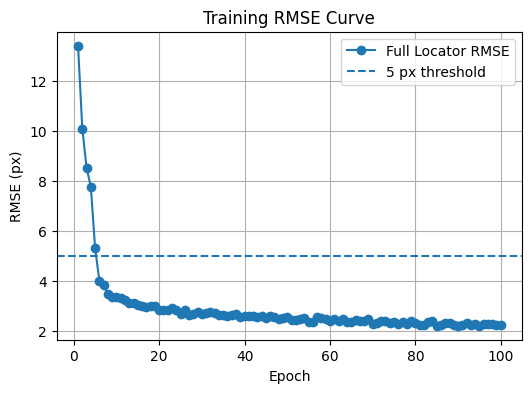

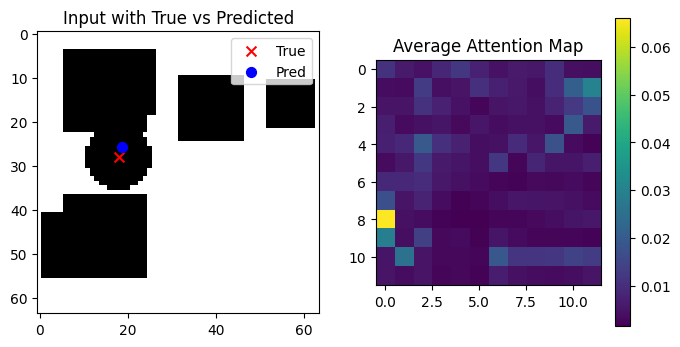

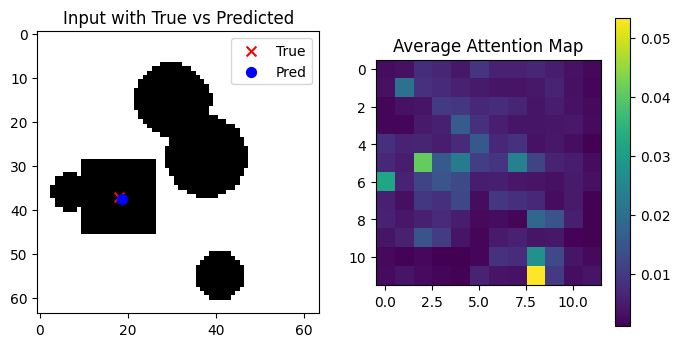

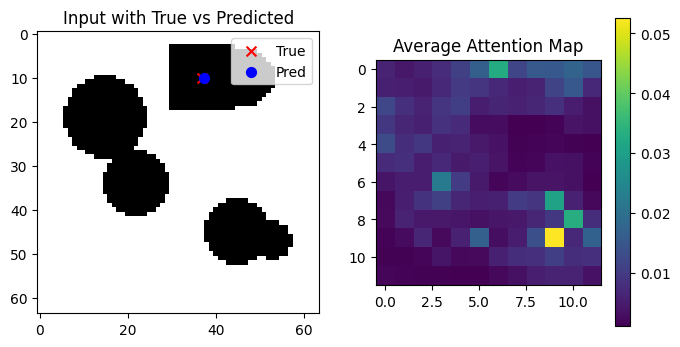

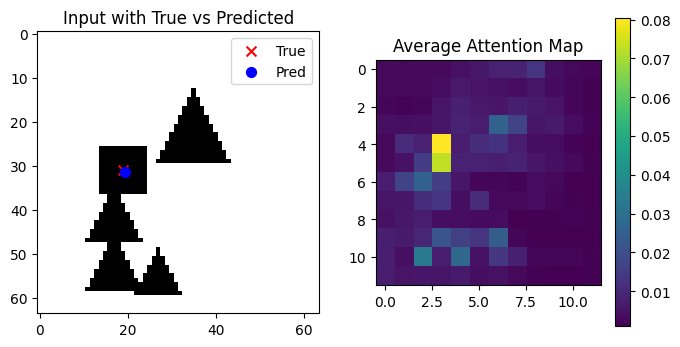

In [1]:
import torch, random, math, numpy as np
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# -------------------------------
# 0. Reproducibility and Setup
# -------------------------------
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------------
# 1. Online Dataset Definition
# -------------------------------
IMAGE = 64
SHAPES = ("circle","square","triangle")

def draw_shape(draw, s, cx, cy, r):
    if s == "circle":
        draw.ellipse([cx-r, cy-r, cx+r, cy+r], fill="black")
    elif s == "square":
        draw.rectangle([cx-r, cy-r, cx+r, cy+r], fill="black")
    else:
        draw.polygon([(cx,cy-r),(cx-r,cy+r),(cx+r,cy+r)], fill="black")

class OddXYDataset(Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples  # number of online draws
    def __len__(self):
        return self.num_samples
    def __getitem__(self, idx):
        # Create blank image: img -> Tensor shape (1,64,64)
        img = Image.new("L", (IMAGE, IMAGE), "white")
        d = ImageDraw.Draw(img)
        base = random.choice(SHAPES)
        for _ in range(random.randint(3,6)):
            r  = random.randint(4,10)
            cx = random.randint(r, IMAGE-r-1); cy = random.randint(r, IMAGE-r-1)
            draw_shape(d, base, cx, cy, r)
        odd = random.choice([s for s in SHAPES if s != base])
        r  = random.randint(4,10)
        cx = random.randint(r, IMAGE-r-1); cy = random.randint(r, IMAGE-r-1)
        draw_shape(d, odd, cx, cy, r)
        img_t = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.0  # (1,64,64)
        lbl   = torch.tensor([float(cx), float(cy)], dtype=torch.float32)             # (2,)
        return img_t, lbl

# -------------------------------
# 2. Positional Encoding Module
# -------------------------------
class PosEnc(nn.Module):
    def __init__(self, d_model, L):
        super().__init__()
        pe = torch.zeros(L, d_model)             # (L,d_model)
        pos = torch.arange(L).unsqueeze(1).float()# (L,1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000)/d_model))
        pe[:,0::2], pe[:,1::2] = torch.sin(pos*div), torch.cos(pos*div)
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x: (B, L, d_model)
        return x + self.pe.unsqueeze(0)  # returns (B, L, d_model)

# -------------------------------
# 3. Encoder: Conv -> Tokens -> PosEnc
# -------------------------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # conv: input (B,1,64,64) -> (B,32,64,64) -> (B,16,12,12)
        self.conv = nn.Sequential(
            nn.Conv2d(1,32, kernel_size=3, padding=1),  # -> (B,32,64,64)
            nn.ReLU(),
            nn.Conv2d(32,16, kernel_size=20, stride=4),  # -> (B,16,12,12)
            nn.ReLU()
        )
        self.L, self.d = 12*12, 16
        self.pos_enc = PosEnc(self.d, self.L)
    def forward(self, x):
        f = self.conv(x)                                 # f: (B,16,12,12)
        tokens = f.flatten(2).transpose(1,2)             # tokens: (B,144,16)
        out = self.pos_enc(tokens)                      # out: (B,144,16)
        return out

# -------------------------------
# 4. Full Locator: Coarse+Offset
# -------------------------------
class LocatorFull(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.enc = encoder
        d, L = encoder.d, encoder.L
        self.attn   = nn.MultiheadAttention(d, num_heads=4, batch_first=True)
        self.ln1    = nn.LayerNorm(d)
        self.ff     = nn.Sequential(nn.Linear(d,64), nn.ReLU(), nn.Dropout(0.1), nn.Linear(64,d))
        self.ln2    = nn.LayerNorm(d)
        self.cls    = nn.Sequential(nn.Linear(d,32), nn.ReLU(), nn.Dropout(0.1), nn.Linear(32,1))
        self.offset = nn.Sequential(nn.Linear(d,32), nn.ReLU(), nn.Dropout(0.1), nn.Linear(32,2))
        # Precomputed grid centers for each token
        coords = [[(i%12)*4 + 10, (i//12)*4 + 10] for i in range(L)]
        self.register_buffer('centers', torch.tensor(coords, dtype=torch.float32))  # (144,2)
    def forward(self, x):
        B = x.size(0)
        z, attn_weights = None, None
        z = self.enc(x)                                # z: (B,144,16)
        attn_out, attn_weights = self.attn(z, z, z, need_weights=True)  # attn_out: (B,144,16), attn_weights: (B,144,144)
        y = self.ln1(z + attn_out)                     # y: (B,144,16)
        ff = self.ff(y)                                # ff: (B,144,16)
        z2 = self.ln2(y + ff)                          # z2: (B,144,16)
        logits = self.cls(z2).squeeze(-1)              # logits: (B,144)
        P = F.softmax(logits, dim=-1)                  # P: (B,144)
        centers = self.centers.unsqueeze(0).expand(B,-1,-1)  # (B,144,2)
        coarse = torch.bmm(P.unsqueeze(1), centers).squeeze(1)  # coarse: (B,2)
        offs   = self.offset(z2)                       # offs: (B,144,2)
        fine   = torch.bmm(P.unsqueeze(1), offs).squeeze(1)     # fine: (B,2)
        return coarse + fine, attn_weights            # coords: (B,2), attn_weights: (B,144,144)

# -------------------------------
# 5. Training Loop & Loss Plot
# -------------------------------
enc    = Encoder().to(device)
model  = LocatorFull(enc).to(device)
opt    = torch.optim.Adam(model.parameters(), lr=1e-3)
crit   = nn.MSELoss()
loader = DataLoader(OddXYDataset(25000), batch_size=64, shuffle=True, num_workers=2)

epochs = 100
rmse_list = []
print("Training Full Locator...")
for ep in range(1, epochs+1):
    total_loss = 0.0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds, _ = model(imgs)                        # preds: (B,2)
        loss = crit(preds, lbls)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()
    rmse = math.sqrt(total_loss / len(loader))
    rmse_list.append(rmse)
    print(f" Epoch {ep:02d}/{epochs}: RMSE={rmse:.3f}")

# Plot RMSE curve with threshold
plt.figure(figsize=(6,4))
plt.plot(range(1, len(rmse_list)+1), rmse_list, marker='o', label='Full Locator RMSE')
plt.axhline(5.0, linestyle='--', label='5 px threshold')
plt.xlabel('Epoch'); plt.ylabel('RMSE (px)')
plt.title('Training RMSE Curve'); plt.legend(); plt.grid(True)
plt.show()

# -------------------------------
# 6. Attention Visualization
# -------------------------------
# Visualize attention maps for a batch of samples
imgs, lbls = next(iter(loader))
imgs = imgs[:4].to(device)  # select first 4
coords, attn_w = model(imgs)  # coords: (4,2), attn_w: (4,144,144)
for i in range(4):
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    # show image
    ax[0].imshow(imgs[i].cpu().squeeze(), cmap='gray')
    ax[0].scatter([lbls[i][0]], [lbls[i][1]], s=50, c='r', marker='x', label='True')
    ax[0].scatter([coords[i][0].item()], [coords[i][1].item()], s=50, c='b', marker='o', label='Pred')
    ax[0].legend(); ax[0].set_title('Input with True vs Predicted')
    # attention map: average over query tokens
    avg_attn = attn_w[i].mean(dim=0).reshape(12,12).cpu().detach().numpy()
    im = ax[1].imshow(avg_attn, cmap='viridis')
    ax[1].set_title('Average Attention Map')
    fig.colorbar(im, ax=ax[1])
    plt.show()